# 8 Uncertainty Decomposition

This notebook presents compuations in section 8 of the paper.

To check the previous section:

[Section 7: Sensitivity](sec7_Sensitivity.ipynb)

We use social cost of carbon as a measure to study the relative contribution of temperature models, carbon models and damages to uncertainty.

Here, we set $\xi_b = + \infty$, and study two configurations of $(\xi_a, \xi_p)$: $(0.01, 5)$ and $(0.01, 0.3)$.

In [54]:
# packages
import pandas as pd
import numpy as np
from source.model import solve_hjb_y, solve_hjb_y_jump, uncertainty_decomposition
from source.utilities import find_nearest_value
from source.simulation import simulate_me
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'ggplot2'

In [2]:
# preparation
ξ_w = 100_000
ξ_a = 0.01
ξ_p = 5

ϵ = 5.
η = .032
δ = .01

θ_list = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ_list)/len(θ_list)

σ_y = 1.2*np.mean(θ_list)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., y_bar+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ_list.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_m (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p_i, θ_list, πc_o, ξ_w, ξ_a) 
    model_res = solve_hjb_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_iteration=False)
    ϕ_list.append(model_res['v'])

ϕ_i_carb_temp = np.array([ϕ_i[:n_bar] for ϕ_i in ϕ_list])

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p_i, θ_carb, πc_o_carb, ξ_w, ξ_a) 
    model_res = solve_hjb_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_iteration=False)
    ϕ_list.append(model_res['v'])

ϕ_i_carb = np.array([ϕ_i[:n_bar] for ϕ_i in ϕ_list])

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p_i, θ_temp, πc_o_temp, ξ_w, ξ_a) 
    model_res = solve_hjb_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_iteration=False)
    ϕ_list.append(model_res['v'])

ϕ_i_temp = np.array([ϕ_i[:n_bar] for ϕ_i in ϕ_list])

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p_i, θ_list, πc_o, ξ_w, 100_000)
    model_res = solve_hjb_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_iteration=False)
    ϕ_list.append(model_res['v'])

ϕ_i_baseline = np.array([ϕ_i[:n_bar] for ϕ_i in ϕ_list])

Converged. Total iteration: 298;	 LHS Error: 9.932442779359008e-09;	 RHS Error 0.00019752149712265465
Converged. Total iteration: 5000;	 LHS Error: 2.0188221006023355e-06;	 RHS Error 0.0008578625921364241
Converged. Total iteration: 5000;	 LHS Error: 1.4506017494930746e-05;	 RHS Error 0.004171072493589326
Converged. Total iteration: 300;	 LHS Error: 9.780709220308381e-09;	 RHS Error 0.00019371704098970766
Converged. Total iteration: 5000;	 LHS Error: 3.0132282567763013e-06;	 RHS Error 0.000857263818996909
Converged. Total iteration: 331;	 LHS Error: 9.62429069772952e-09;	 RHS Error 0.0042019880285099915
Converged. Total iteration: 299;	 LHS Error: 9.746216456107958e-09;	 RHS Error 0.00019231992099913442
Converged. Total iteration: 307;	 LHS Error: 9.930965338966757e-09;	 RHS Error 0.0008631026612177378
Converged. Total iteration: 331;	 LHS Error: 9.744668005851054e-09;	 RHS Error 0.004224429027587198
Converged. Total iteration: 300;	 LHS Error: 9.676233769795316e-09;	 RHS Error 0.00024

In [3]:
# computation
ME_res = dict()
for ξ_p in [5, 0.3]:
    # Compute ϕ
    model_paras = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p, θ_list, πc_o, ϕ_i_carb_temp, πd_o, ξ_w, ξ_p, ξ_a)
    model_res = solve_hjb_y_jump(y_grid_short, model_paras, 
                                 v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0), 
                                 ϵ=ϵ, tol=1e-8, max_iter=5_000, print_iteration=False)
    ME_total = η/model_res['e_tilde']
    # Solve baseline
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_list, πc_o, ϕ_i_baseline, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=np.ones_like(model_res['πc'])/len(θ_list),
                                              bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_baseline = model_res_new['ME']
    
    # Solve temperature uncertainty
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_temp, πc_o_temp, ϕ_i_temp, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=None,
                                              bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_temp = model_res_new['ME']

    # Solve carbon uncertainty
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_carb, πc_o_carb, ϕ_i_carb, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=None,
                                              bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_carb = model_res_new['ME']

    # Solve damage uncertainty
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_list, πc_o, ϕ_i_baseline, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=np.ones_like(model_res['πc'])/len(θ_list),
                                              bc=None,
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_damage = model_res_new['ME']

    # Solve temperature uncertainty + damage uncertainty
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_temp, πc_o_temp, ϕ_i_temp, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=None,
                                              bc=None,
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_temp_damage = model_res_new['ME']

    # Solve carbon uncertainty + damage uncertainty
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_carb, πc_o_carb, ϕ_i_carb, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=None,
                                              bc=None,
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_carb_damage = model_res_new['ME']
    
    # Solve temperature uncertainty + carbon uncertainty
    model_paras_new = (η, δ, σ_y, γ_1, γ_2, θ_list, πc_o, ϕ_i_carb_temp, πd_o, ξ_w, ξ_p, ξ_a)
    model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                              e_tilde=model_res['e_tilde'], 
                                              h=np.zeros_like(model_res['h']),
                                              πc=None,
                                              bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                              v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_iteration=False)  
    ME_temp_carb = model_res_new['ME']
    # store results
    ME_res[ξ_p] = dict(
        e_tilde=model_res['e_tilde'],
        total=ME_total, baseline=ME_baseline,
        carb=ME_carb, temp=ME_temp, damage=ME_damage,
        temp_damage=ME_temp_damage, carb_damage=ME_carb_damage, temp_carb=ME_temp_carb,
    )

Converged. Total iteration: 247;	 LHS Error: 9.279333479383922e-09;	 RHS Error 0.0015635828183588607
Converged. Total iteration: 879;	 LHS Error: 7.930096934671838e-09;	 RHS Error 0.0005528749781223592
Converged. Total iteration: 10000;	 LHS Error: 1.1271747137620026e-05;	 RHS Error 0.0006995319664890309
Converged. Total iteration: 10000;	 LHS Error: 1.383417393787667e-05;	 RHS Error 0.0006102512947000205
Converged. Total iteration: 240;	 LHS Error: 9.104410114701977e-09;	 RHS Error 0.0013784868261165588
Converged. Total iteration: 3358;	 LHS Error: 5.5723011094244155e-09;	 RHS Error 0.0015083614771826126
Converged. Total iteration: 103;	 LHS Error: 4.70399474927774e-09;	 RHS Error 0.0014307608188560382
Converged. Total iteration: 10000;	 LHS Error: 1.2346347701885918e-05;	 RHS Error 0.0007588866477342693
Converged. Total iteration: 5000;	 LHS Error: 1.004161406648052e-05;	 RHS Error 0.003822555814886174
Converged. Total iteration: 116;	 LHS Error: 8.207153001649204e-09;	 RHS Error 0.0

In [5]:
θ_mean = np.mean(θ_list)
simulation_res = dict()
for ξ_p in [5, 0.3]:
    tmp_dict = dict()
    e_tilde = ME_res[ξ_p]['e_tilde']
    ME_total = ME_res[ξ_p]['total']
    ME_baseline = ME_res[ξ_p]['baseline']
    ME_temp = ME_res[ξ_p]['temp']
    ME_carb = ME_res[ξ_p]['carb']
    ME_damage = ME_res[ξ_p]['damage']
    ME_temp_carb =  ME_res[ξ_p]['temp_carb']
    ME_temp_damage =  ME_res[ξ_p]['temp_damage']
    ME_carb_damage =  ME_res[ξ_p]['carb_damage']
    # one type partition
    _, _, tmp_dict['total'] = simulate_me(y_grid_short, e_tilde, np.log(ME_total/ME_baseline)*100, θ=θ_mean)
    _, _, tmp_dict['temp'] = simulate_me(y_grid_short, e_tilde, np.log(ME_temp/ME_baseline)*100, θ=θ_mean)
    _, _, tmp_dict['carb'] = simulate_me(y_grid_short, e_tilde, np.log(ME_carb/ME_baseline)*100, θ=θ_mean)
    _, _, tmp_dict['damage'] = simulate_me(y_grid_short, e_tilde,np.log(ME_damage/ME_baseline)*100, θ=θ_mean)
    # two type partition
    _, _, tmp_dict['temp_damage']= simulate_me(y_grid_short, e_tilde, 
                                                np.log(ME_temp_damage/ME_baseline)*100, θ=θ_mean)
    _, _, tmp_dict['carb_damage'] = simulate_me(y_grid_short, e_tilde, 
                                          np.log(ME_carb_damage/ME_baseline)*100, θ=θ_mean)
    _, _, tmp_dict['temp_carb'] = simulate_me(y_grid_short, e_tilde, 
                                          np.log(ME_temp_carb/ME_baseline)*100, θ=θ_mean)
    simulation_res[ξ_p] = tmp_dict

(0.0, 50.0)

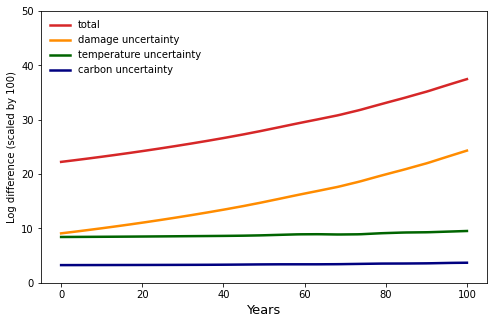

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

_, _, total_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)
_, _, temp_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)
_, _, carb_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)
_, _, damage_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 50)
# plt.savefig('../plots/paper_plots/uncertainty_one_partition.pdf')

(0.0, 50.0)

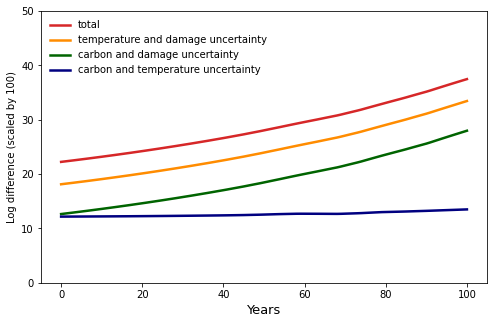

In [6]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)
_, _, temp_damage_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)
_, _, carb_damage_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)
_, _, temp_carb_t = simulate_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ_list), y_start=1., T=100)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 50)
# plt.savefig('../plots/paper_plots/uncertainty_two_partition.pdf')

In [62]:
# Initialize figure
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter"},
                                            {"type": "scatter"}]])

years=np.arange(0,100)
# partition specification
par_one_type = [['total', 'red'], ['damage', 'darkorange'], ['temp', 'darkgreen'], ['carb', 'navy']]
par_two_type = [['total', 'red'], ['temp_damage', 'darkorange'], 
                ['carb_damage', 'darkgreen'], ['temp_carb', 'navy']]
ξ_p_list = [5,0.3]
# Add Traces
for ξ_p in ξ_p_list:
    simulated_ratio = simulation_res[ξ_p]
    for par, color in par_one_type: 
        fig.add_trace(
            go.Scatter(x=years,
                       y=simulated_ratio[par],
                       name=par,
                       visible=False,
                       line=dict(color=color, width=3)), 
            row=1, col=1
        )
    for par, color in par_two_type:
        fig.add_trace(
            go.Scatter(x=years,
                       y=simulated_ratio[par],
                       name=par,
                       visible=False,
                       line=dict(color=color, width=3)), 
            row=1, col=2
        )
num_line = int(len(fig.data)/len(ξ_p_list))
for i in range(num_line):
    fig.data[i].visible = True
    
buttons = list()
for i in range(len(ξ_p_list)):
    button = dict(
        method='update',
        args=[{'visible': [False]*len(fig.data)}],
        label='ξ_a = 0.01 and ξ_p = {}'.format(ξ_p_list[i])
    )
    for j in range(num_line):
        button['args'][0]['visible'][i*num_line+j] = True
    buttons.append(button)

fig.update_layout(
    title=dict(
        text='Uncertainty decomposition',
        x=0.1
    ),
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            y=1.2,
            x=0.8,
            active=0,
            buttons=buttons,
            bgcolor='#e7e3da',
        )
    ])

fig.update_xaxes(range=[0, 100], title='Years')
fig.update_yaxes(rangemode='tozero', title='log difference (scaled by 100)', row=1, col=1)

fig.show()